In [1]:
#SETUP & Load data

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

#for hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV



DATA_PATH = "preprocessed_ml"
IMG_SIZE = 64

# verification
if os.path.exists(DATA_PATH):
    print(f"dataset at: {DATA_PATH}")
    print("Classes found:", os.listdir(DATA_PATH))
else:
  # exception handling
    print(f"Could not find {DATA_PATH}.")


dataset at: preprocessed_ml
Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [2]:
#loading & flattening data

data = []
labels = []
classes = sorted(os.listdir(DATA_PATH)) # for consistent order

print("Loading and flattening images...")

for category in classes:
    path = os.path.join(DATA_PATH, category)
    # Check if it's actually a directory
    if not os.path.isdir(path):
        continue

    class_num = classes.index(category)

    # Loop through images
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img_array = cv2.imread(img_path)

            # Safety check: Ensure image loaded correctly
            if img_array is None:
                continue

            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

            # --- CRITICAL STEP: FLATTENING ---
            # 64x64x3 = 12,288 features
            flat_data = img_array.flatten()

            data.append(flat_data)
            labels.append(class_num)
        except Exception as e:
            pass

X = np.array(data, dtype=np.float32)
y = np.array(labels)

print(f"Loaded {len(X)} images.")
print(f"Data Shape: {X.shape}") # Should be (27000, 12288)

Loading and flattening images...
Loaded 27000 images.
Data Shape: (27000, 12288)


In [3]:
#split into sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nFull train/test split:")
print("  X_train:", X_train.shape)
print("  X_test :", X_test.shape)


Full train/test split:
  X_train: (21600, 12288)
  X_test : (5400, 12288)


In [4]:
#RandomizedSearchCV hyperparameter tuning on a subset of the preprocessed dataset

subset_size = min(3000, len(X_train))
idx = np.random.choice(len(X_train), subset_size, replace=False)

X_sub = X_train[idx]
y_sub = y_train[idx]

print(f"\nUsing subset of size {subset_size} for RandomizedSearchCV")

param_distributions = {
    "n_estimators": randint(50, 300),
    "max_depth": [10, 20, None],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 4),
    "bootstrap": [True, False],
}

base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=15,       
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy",
    random_state=42
)

print("\nStarting RandomizedSearchCV on subset...")
search.fit(X_sub, y_sub)

print("\nBest params:")
print(search.best_params_)

best_params = search.best_params_ #optimised parameters


Using subset of size 3000 for RandomizedSearchCV

Starting RandomizedSearchCV on subset...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 224}


In [5]:
#train with optimised parameters
model = RandomForestClassifier(
    n_estimators=best_params.get("n_estimators", 100),
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    bootstrap=best_params["bootstrap"],
    n_jobs=-1,
    random_state=42
)

print("Training tuned RF on raw X...")
model.fit(X_train, y_train)

Training tuned RF on raw X...


RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=7,
                       n_estimators=224, n_jobs=-1, random_state=42)

🏆 Model Accuracy: 69.94%


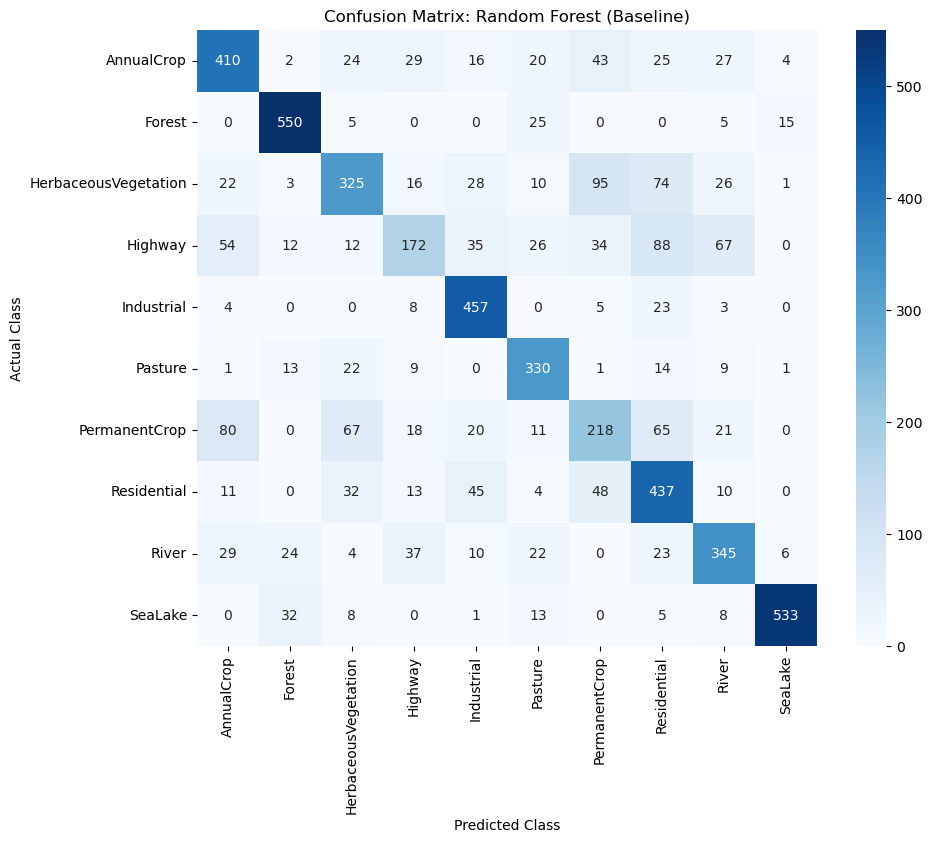

                      precision    recall  f1-score   support

          AnnualCrop       0.67      0.68      0.68       600
              Forest       0.86      0.92      0.89       600
HerbaceousVegetation       0.65      0.54      0.59       600
             Highway       0.57      0.34      0.43       500
          Industrial       0.75      0.91      0.82       500
             Pasture       0.72      0.82      0.77       400
       PermanentCrop       0.49      0.44      0.46       500
         Residential       0.58      0.73      0.65       600
               River       0.66      0.69      0.68       500
             SeaLake       0.95      0.89      0.92       600

            accuracy                           0.70      5400
           macro avg       0.69      0.70      0.69      5400
        weighted avg       0.69      0.70      0.69      5400



In [6]:
#Evaluation
y_pred = model.predict(X_test)

# 1. Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"🏆 Model Accuracy: {acc * 100:.2f}%")

# 2. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: Random Forest (Baseline)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# 3. Text Report
print(classification_report(y_test, y_pred, target_names=classes))